Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


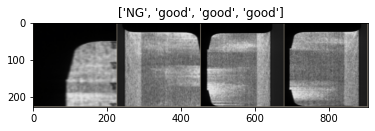

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4922 Acc: 0.7746
val Loss: 0.0495 Acc: 0.9833

Epoch 1/24
----------
train Loss: 0.5255 Acc: 0.8279
val Loss: 0.0095 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.5791 Acc: 0.8607
val Loss: 0.0155 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2617 Acc: 0.9344
val Loss: 0.1846 Acc: 0.9333

Epoch 4/24
----------
train Loss: 0.1013 Acc: 0.9549
val Loss: 0.0064 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2067 Acc: 0.9549
val Loss: 0.0016 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3586 Acc: 0.9016
val Loss: 0.0020 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1565 Acc: 0.9385
val Loss: 0.0037 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1864 Acc: 0.9139
val Loss: 0.0031 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1724 Acc: 0.9303
val Loss: 0.0036 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2281 Acc: 0.9221
val Loss: 0.0068 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1732 Acc: 0.9344
val Loss: 0.0039 Acc: 1.0000

Epoch 12/24
----------
t

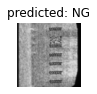

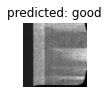

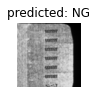

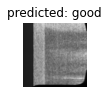

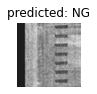

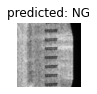

In [2]:
%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

from google.colab import drive
drive.mount('/content/drive')

data_transforms = {
    'train' : transforms.Compose([
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip( ),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'val' : transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                
    ]),
}

data_dir = '/content/drive/My Drive/hymenoptera_data'
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None :
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25) :
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs) :
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    for phase in ['train', 'val'] :
      if phase == 'train' :
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      for inputs, labels in dataloaders[phase] :
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train') :
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train' :
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'val' and epoch_acc > best_acc :
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model

def visualize_model(model, num_images = 6) :
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad() :
    for i, (inputs, labels) in enumerate(dataloaders['val']) :
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images :
          model.train(mode = was_training)
          return
    model.train(mode = was_training)

model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

visualize_model(model_ft)